# Dataset Presentation

The dataset we will use for this exercise is the "Web Traffic Anomaly Detection" dataset. This dataset, collected through AWS CloudWatch, provides web traffic records aimed at identifying suspicious activities and potential attack attempts. You can find the dataset at the provided directory: `../datasets/CloudWatch_Traffic_Web_Attack.csv`.

**Features of the Dataset:**

1. **bytes_in:** The amount of data (in bytes) received by the server during the connection.
2. **bytes_out:** The amount of data (in bytes) sent from the server during the connection.
3. **creation_time:** The timestamp when the traffic record was created.
4. **end_time:** The timestamp when the connection ended.
5. **src_ip:** The IP address of the source sending traffic to the server.
6. **src_ip_country_code:** The country code of the source IP address.
7. **protocol:** The protocol used for the connection (e.g., HTTP, HTTPS).
8. **response.code:** The HTTP response code sent by the server.
9. **dst_port:** The destination port on the server.
10. **dst_ip:** The IP address of the server receiving the traffic.
11. **rule_names:** The names of the detection rules that flagged the traffic as suspicious.
12. **observation_name:** Observations related to the detected traffic.
13. **source.meta:** Metadata associated with the source of the traffic.
14. **source.name:** The name of the traffic source.
15. **time:** The timestamp of when the event was detected.
16. **detection_types:** The types of detection mechanisms applied to identify suspicious traffic.

#### Problem Definition

**Objective:**
We aim to identify and analyze anomalous web traffic patterns to enhance threat detection capabilities. The goal is to develop models that can detect unusual behaviors in web traffic (`rule_names` and `detection_types`) using various features such as `bytes_in`, `bytes_out`, `protocol`, `src_ip`, `src_ip_country_code`, `dst_port`, and other relevant metadata.

**Why This Problem is Interesting:**
Detecting anomalous web traffic is critical for several reasons:
- **For Security Teams:** Enhances the ability to respond to and mitigate cyber threats in real time, reducing the risk of data breaches and service disruptions.
- **For System Administrators:** Helps in maintaining the integrity and performance of web servers by identifying and managing potential attack vectors.
- **For Researchers and Developers:** Provides a practical dataset to develop and test new anomaly detection algorithms, contributing to advancements in cybersecurity.

In an industry where cybersecurity is increasingly vital, leveraging such a dataset can significantly improve an organization's defense mechanisms against evolving cyber threats.

# Workflow

Here to talk about the Workflow

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data Import and Visualization

In [2]:
# Load the dataset
data = pd.read_csv('../datasets/CloudWatch_Traffic_Web_Attack.csv')

# Data exploration
print(data.head())
print(data.info())
print(data.describe())
print(data.columns)

   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Suspicious Web Traffic  

In [3]:
# Describe the numerical columns
print(data.describe())

           bytes_in     bytes_out  response.code  dst_port
count  2.820000e+02  2.820000e+02          282.0     282.0
mean   1.199390e+06  8.455429e+04          200.0     443.0
std    4.149312e+06  2.549279e+05            0.0       0.0
min    4.000000e+01  4.400000e+01          200.0     443.0
25%    5.381500e+03  1.114200e+04          200.0     443.0
50%    1.318200e+04  1.379950e+04          200.0     443.0
75%    3.083300e+04  2.627950e+04          200.0     443.0
max    2.520779e+07  1.561220e+06          200.0     443.0


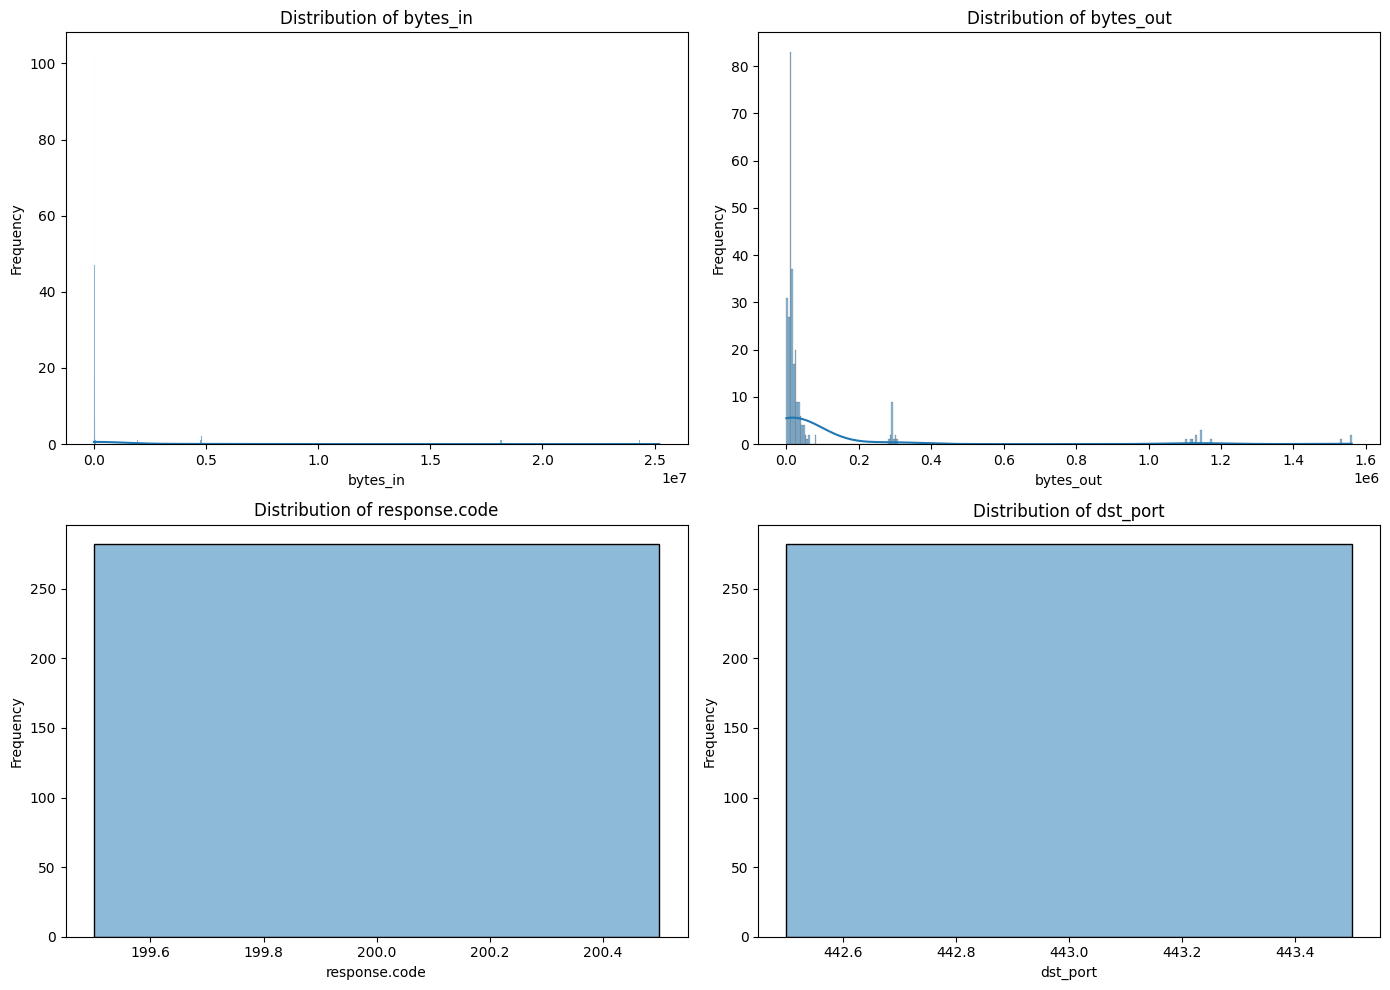

In [4]:
# Plot distributions of numerical features
numerical_features = ['bytes_in', 'bytes_out', 'response.code', 'dst_port']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

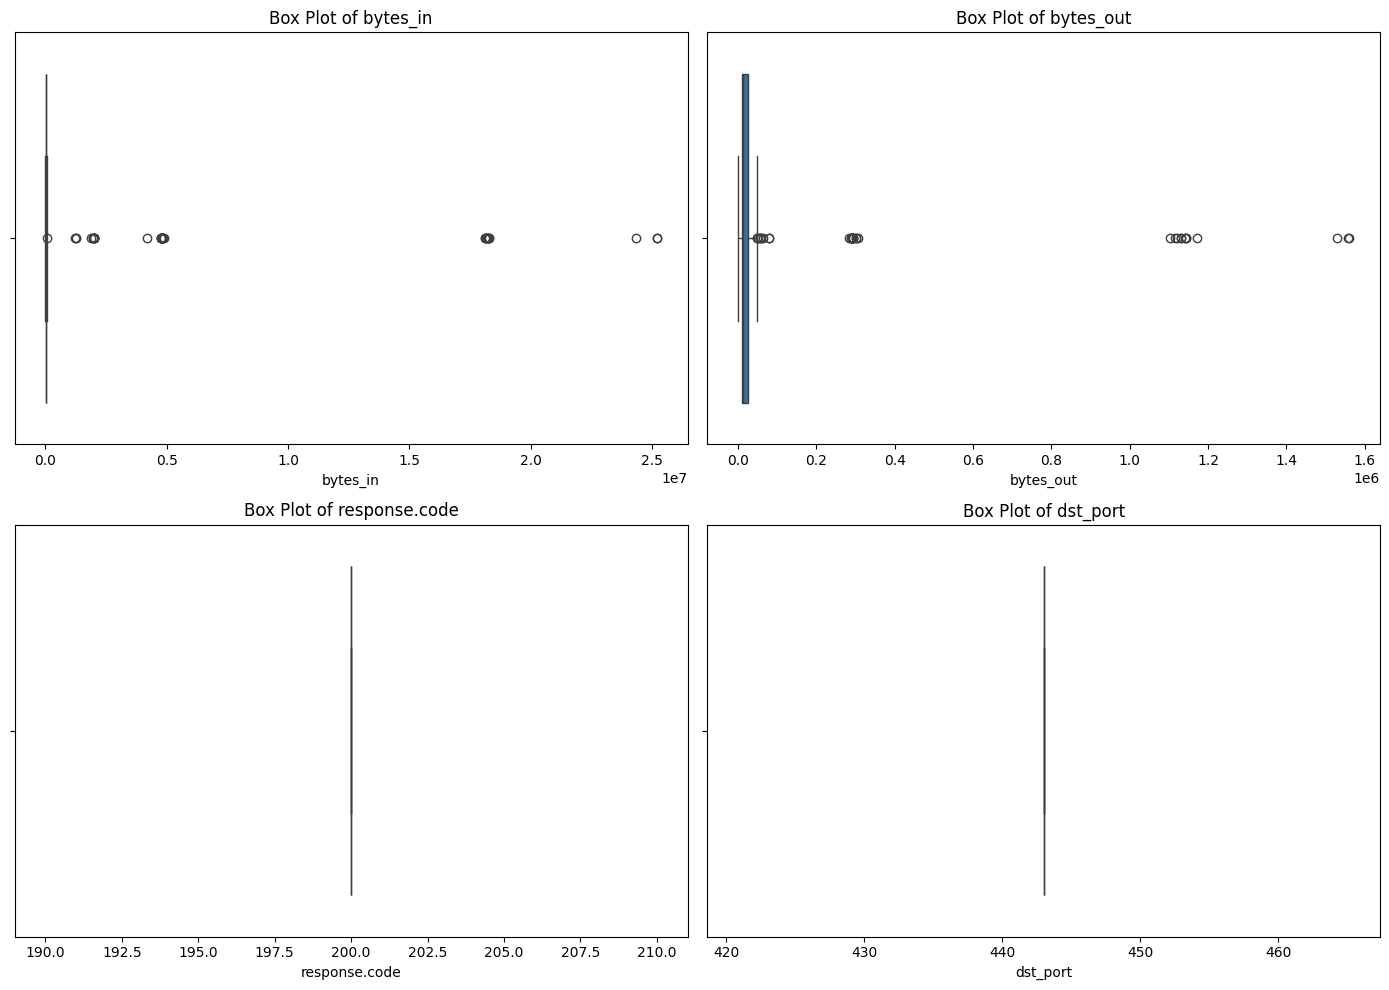

In [5]:
# Box plots to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

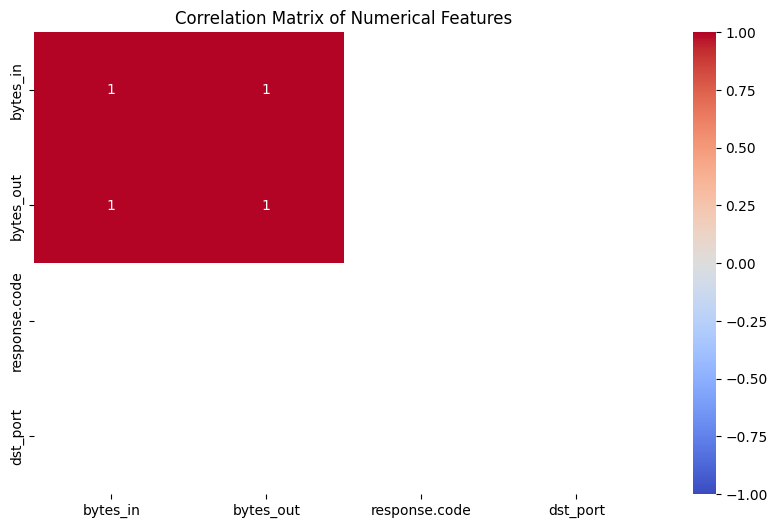

In [6]:
# Calculate correlation matrix
corr_matrix = data[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

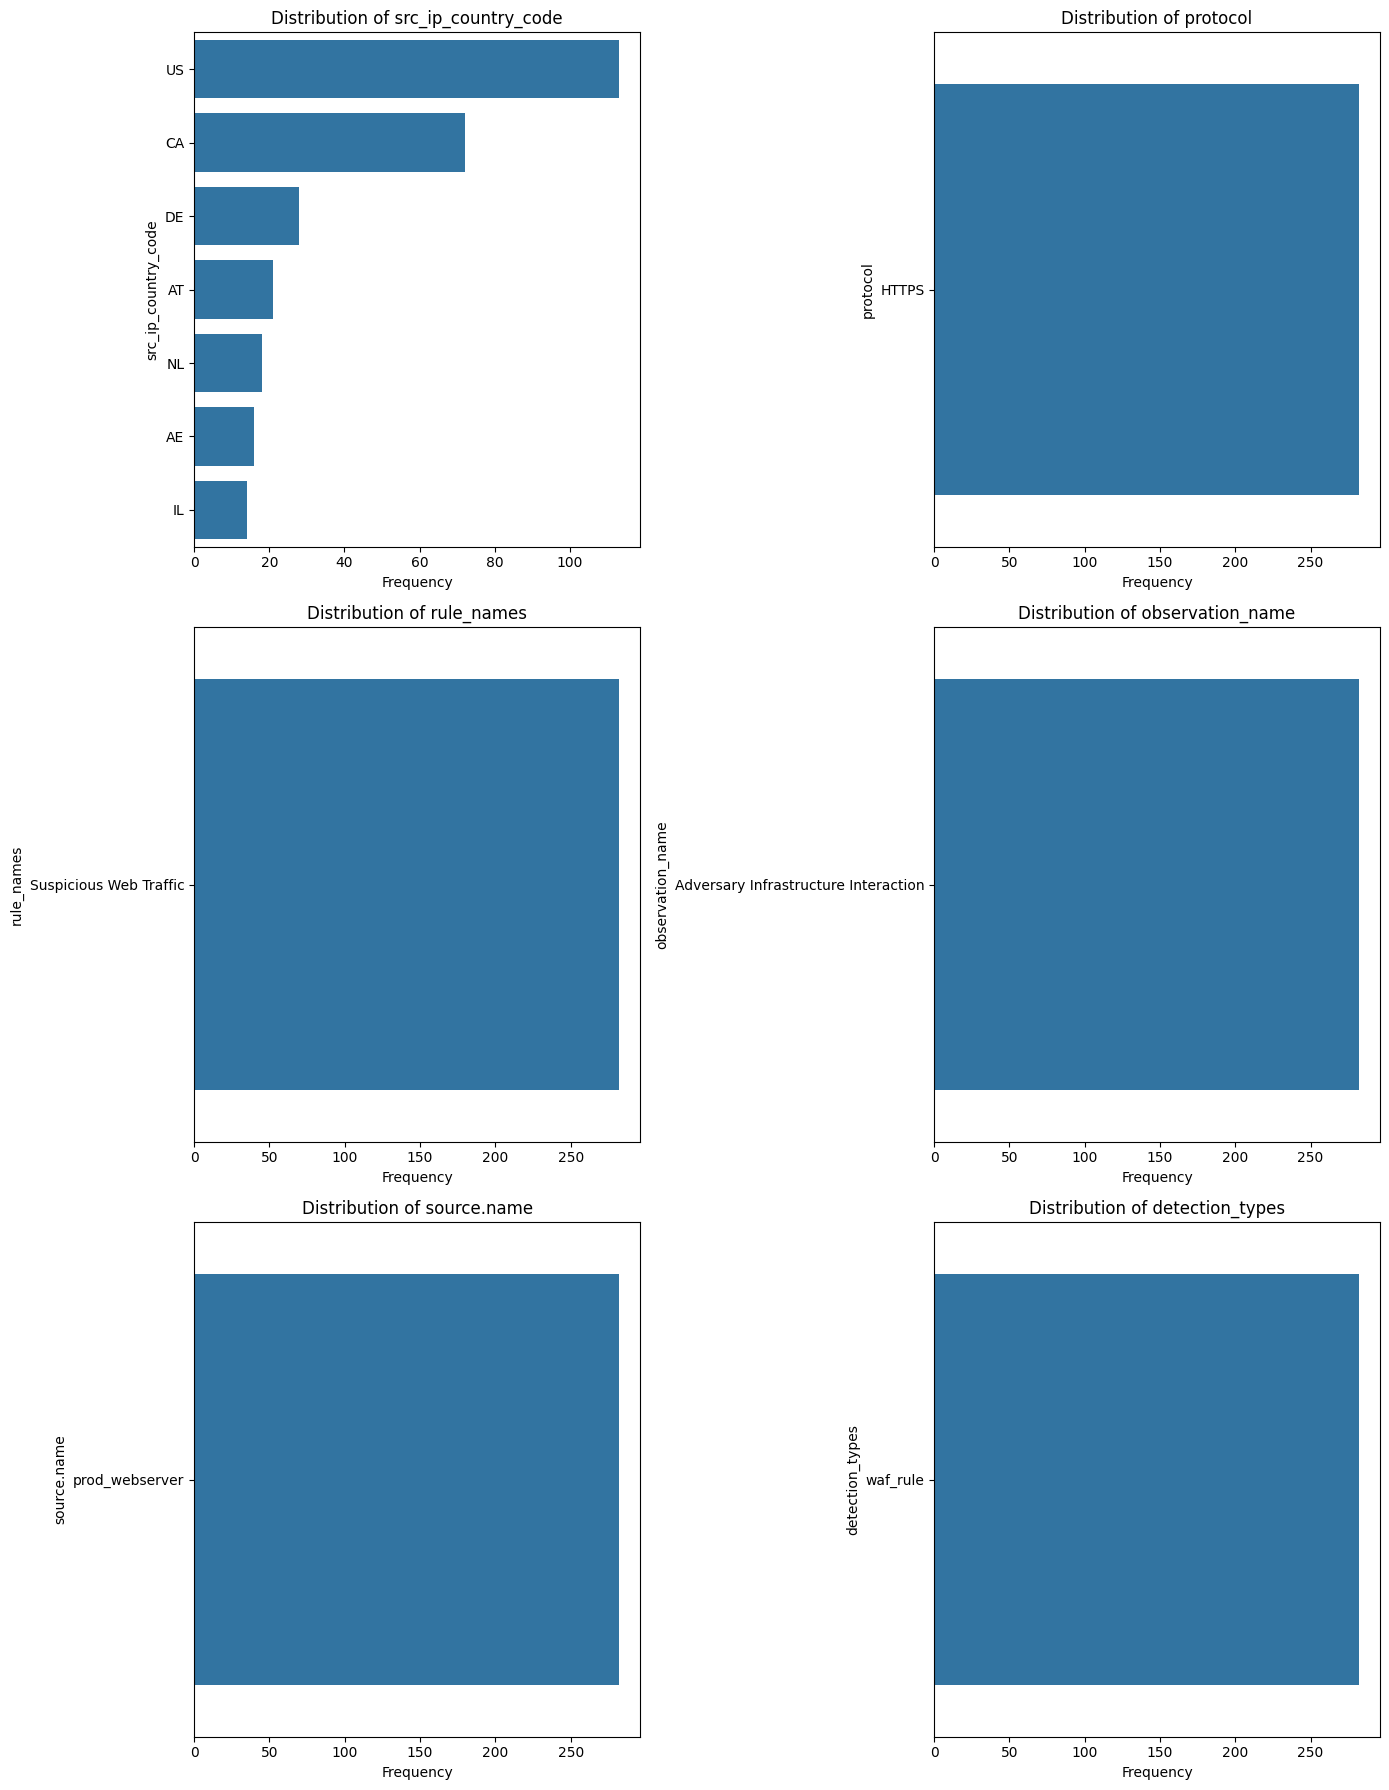

In [7]:
# Categorical features
categorical_features = ['src_ip_country_code', 'protocol', 'rule_names', 'observation_name', 'source.name', 'detection_types']

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(y=data[feature], ax=axes[i], order=data[feature].value_counts().index)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Preprocessing

In [8]:
# Drop non-relevant columns for unsupervised learning
unsupervised_data = data.drop(columns=['creation_time', 'end_time', 'time', 'src_ip', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name'])

# Define numerical and categorical features
numerical_features = ['bytes_in', 'bytes_out', 'response.code', 'dst_port']
categorical_features = ['src_ip_country_code', 'protocol', 'detection_types']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [9]:
# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)

# KMeans clustering pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit Pipeline

In [10]:
# Fit the pipeline to the data
pipeline.fit(unsupervised_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bytes_in', 'bytes_out',
                                                   'response.code',
                                                   'dst_port']),
                                                 ('cat', OneHotEncoder(),
                                                  ['src_ip_country_code',
                                                   'protocol',
                                                   'detection_types'])])),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [13]:
# Transform the data using the preprocessor and PCA for silhouette score
preprocessed_data = pipeline.named_steps['preprocessor'].transform(unsupervised_data)
preprocessed_data = pipeline.named_steps['pca'].transform(preprocessed_data)

# Get cluster labels and add to a copy of the original data
data_copy = unsupervised_data.copy()
data_copy['cluster'] = pipeline.named_steps['kmeans'].labels_

# Evaluate the clustering
silhouette_avg = silhouette_score(preprocessed_data, data_copy['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.518343718639374


# Visualize Model

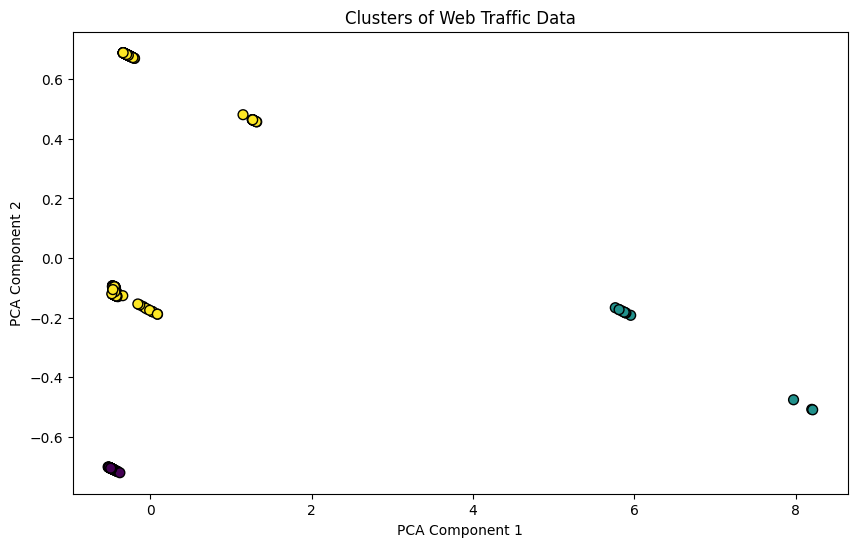

In [15]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(preprocessed_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=data_copy['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Web Traffic Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Summary of Results

Here to discuss the conclusion